# До.за. №2. DE-EN

Попробуйте адаптировать код из семинара для решения задачи перевода текстов с немецкого на английский язык.

[Оригинал](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

Попробуем не копируя оригинал переложить генератор кода по запросу на перевод с немецкого на английский

In [1]:
QUICK_RUN = True    # использовать уже готовую модель

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt

import spacy

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
device

device(type='cuda')

### Еще полезные штуки

- Таблица параметров модели. Типа подробный `get_parameters()` 
- Все тензоры ноутбука
- Очистить память от ненужных тензоров/моделей

In [ ]:
from helpers.summary import count_parameters, dump_tensors, free_mem

### Посмотрим, что представляют собой данные

Torchtext автоматически загружает файлы из датасета `Multi30k` при вызове `Multi30k.splits(...)`(или использует уже скачанные ранее файлы) и хранит их в папке `.data`, если не указано обратное (можно указать, где Вы хотите хранить датасет в параметре `root` при вызове `Multi30k.splits(...)`)

Внутри папки `root/multi30k` будут лежать текстовые файлы train.de, train.en,  val.de,  val.en и т.д. (внутри сырые предложения, разделенные переносом строки).

In [8]:
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [9]:
import en_core_web_sm
import de_core_news_sm

spacy_de = de_core_news_sm.load() 
spacy_en = en_core_web_sm.load() 

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(
    exts = ('.de', '.en'), 
    fields = (SRC, TRG), 
    root = './datasets'
)

### Cформируем словарь

Задаём максимально возможный размер слоя и минимальную встречаемость слова для того, чтобы попасть в словарь (3 для вопросов, 5 для кода).

Чтобы использовать паддинг, `torchtext` требует, чтобы все элементы в батче были отсортированы по их длине до применения паддинга, в убывающем порядке. То есть, первая последовательность должна быть самой длинной

In [10]:
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Уникальные токены в словаре DE: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре EN: {len(TRG.vocab)}")

[('.', 28808), ('ein', 18851), ('einem', 13711), ('in', 11894), ('eine', 9909), (',', 8938), ('und', 8925), ('mit', 8843), ('auf', 8745), ('mann', 7805), ('einer', 6765), ('der', 4989), ('frau', 4186), ('die', 3949), ('zwei', 3872), ('einen', 3479), ('im', 3106), ('an', 3062), ('von', 2363), ('sich', 2273)]
[('a', 49165), ('.', 27622), ('in', 14886), ('the', 10955), ('on', 8035), ('man', 7781), ('is', 7525), ('and', 7379), ('of', 6871), ('with', 6179), ('woman', 3973), (',', 3962), ('two', 3885), ('are', 3716), ('to', 3128), ('people', 3122), ('at', 2927), ('an', 2861), ('wearing', 2623), ('shirt', 2324)]
Уникальные токены в словаре DE: 5374
Уникальные токены в словаре EN: 3270


In [11]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 29000
Размер валидационной выборки: 1014
Размер тестовой выборки: 1000


### Класс энкодера


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))    # dropout(!)
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.detach().cpu())   # тензор длины д.б. на хосте
        packed_outputs, hidden = self.rnn(packed_embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 

        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Механизм внутреннего внимания


In [13]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Класс декодера

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

### Seq2seq модель

Объединяет все это в кучу.

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

### Итератор для батчей

In [16]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

# Инициализация модели


In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 50
DEC_HID_DIM = 50
ENC_DROPOUT = 0.7
DEC_DROPOUT = 0.7
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

Так задаются в торче пользовательские функции иницализации:
- параметры веса - нормальный шум
- остальные параметры - 0

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5374, 64)
    (rnn): GRU(64, 50, bidirectional=True)
    (fc): Linear(in_features=100, out_features=50, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=150, out_features=50, bias=True)
    )
    (embedding): Embedding(3270, 64)
    (rnn): GRU(164, 50)
    (out): Linear(in_features=214, out_features=3270, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)

In [19]:
count_parameters(model)

+----------------------------------+-----+------------+------------+---------------+----------+
|         Modules/Tensors          | GPU |   Shape    | Parameters |      Type     |  Memory  |
+----------------------------------+-----+------------+------------+---------------+----------+
|     encoder.embedding.weight     |  +  | 5374 x 64  |   343936   | torch.float32 | 30266368 |
|     encoder.rnn.weight_ih_l0     |  +  |  150 x 64  |    9600    | torch.float32 |  844800  |
|     encoder.rnn.weight_hh_l0     |  +  |  150 x 50  |    7500    | torch.float32 |  660000  |
|      encoder.rnn.bias_ih_l0      |  +  |    150     |    150     | torch.float32 |  13200   |
|      encoder.rnn.bias_hh_l0      |  +  |    150     |    150     | torch.float32 |  13200   |
| encoder.rnn.weight_ih_l0_reverse |  +  |  150 x 64  |    9600    | torch.float32 |  844800  |
| encoder.rnn.weight_hh_l0_reverse |  +  |  150 x 50  |    7500    | torch.float32 |  660000  |
|  encoder.rnn.bias_ih_l0_reverse  |  + 

1336116

In [20]:
optimizer = optim.Adam(model.parameters())

In [21]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

## Обучение модели

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg, 0.4)    #turn ON teacher forcing
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Также у нас есть функция, которую мы будем использовать для оценивания качества модели (для evaluate). Здесь, вначале, мы переводим нашу модель в состояние оценивания качества (это означает "выключить dropout", "выключить батч-нормализацию") и дальше проделываем примерно такие же шаги, как и в функции "train".

In [23]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len, trg, 0.0)   #turn OFF teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Перплексия** в теории информации — безразмерная величина, мера того, насколько хорошо распределение вероятностей предсказывает выборку. Низкий показатель перплексии указывает на то, что распределение вероятности хорошо предсказывает выборку.

Формула перплексии:

$$PP(W) = P(w_1, w_2, .., w_N)^{-\frac{1}{N}} = \sqrt[N]{\dfrac{1}{P(w_1, w_2, .., w_N)}} = \sqrt[N]{\dfrac{1}{\prod_{i=1}^N P(w_i | w_1, .., w_{i-1})}}$$


20 сек. / эпоха

Минимум 50 эпох

In [25]:
N_EPOCHS = 50
CLIP = 1        # более высокие градиенты обрезаются до этого значения

best_valid_loss = float('inf')

if not QUICK_RUN:  
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), './models/DE-EN_model_attention_test.pt')
        
        print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s')
        print(f' -> Перплексия  (обучение / валидация): {math.exp(train_loss):7.3f} / {math.exp(valid_loss):7.3f}')

In [26]:
if QUICK_RUN:
    model.load_state_dict(torch.load('./models/DE-EN_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)
print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация):  23.025


## Перевод текста DE -> EN

In [27]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_de(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)])
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [28]:
import numpy as np

def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    ax.matshow(attention, cmap='bone')    # 2д матрица -> тепловая карта
        
    question = ['<sos>'] + [t.lower() for t in tokenize_de(candidate)] + ['<eos>']
    answer = translation
    
    ax.set(xticks=np.arange(attention.shape[-1]),
           yticks=np.arange(attention.shape[0]),
           xticklabels=question, 
           yticklabels=answer,
           title="Карта внимания",
           xlabel='Запрос',
           ylabel='Ответ')
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="default")
    plt.show()
    plt.close()

In [29]:
example_idx = 22

src = ' '.join(vars(train_data.examples[example_idx])['src'][::-1]) # токены в обратном порядке
trg = ' '.join(vars(train_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = ein mann , der ein tattoo auf seinem rücken erhält .
trg = a man getting a tattoo on his back .


predicted trg =  a man is a tattoo on his his .


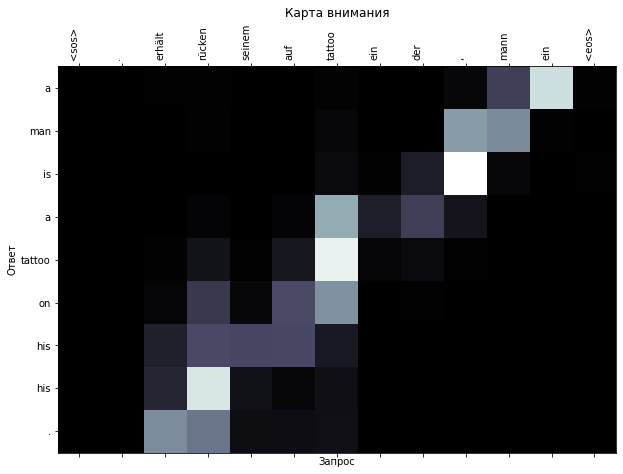

In [30]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [31]:
example_idx = 42

src = ' '.join(vars(train_data.examples[example_idx])['src'][::-1])
trg = ' '.join(vars(valid_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = ein mann geht an einem silbernen fahrzeug vorbei .
trg = a band plays a rock show to a bar audience .


predicted trg =  a man walks past a silver vehicle .


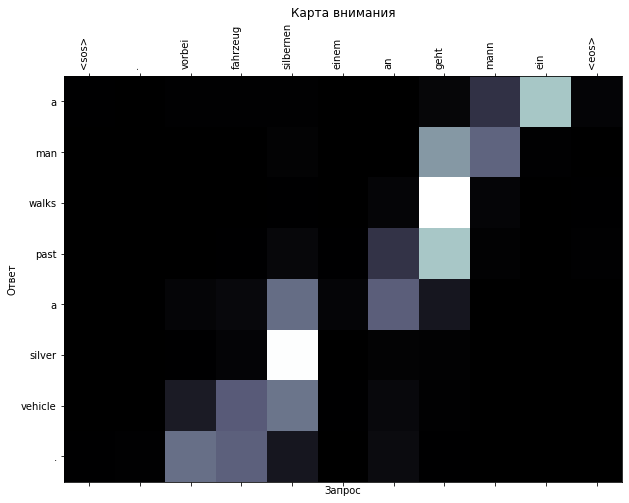

In [32]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [33]:
example_idx = 100

src = ' '.join(vars(train_data.examples[example_idx])['src'][::-1])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = männliches kleinkind in einem roten hut , das sich an einem geländer festhält .
trg = a happy woman is preparing a refreshment at a coffee shop .


predicted trg =  toddlertoddlerinaredhatisonarail.


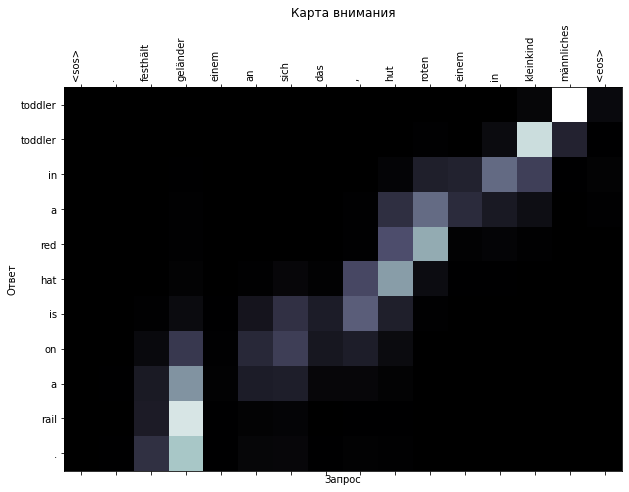

In [34]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ''.join(translation))

display_attention(src, translation, attention)